In [1]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
import matplotlib.pyplot as plt

from src.dataset import GravityDataset
from src.gravity.module import LitGravityModule

%load_ext autoreload
%autoreload 2

# Training

In [6]:
train_dataset = GravityDataset.from_file("data/gravity/gravity_train.npz", target = "acc", scale = 1e-2)
train_loader = DataLoader(train_dataset, batch_size = 512, shuffle = True)

In [7]:
model = LitGravityModule(
    num_atoms=150,
    mlp_sizes=3*[150],
    output_dim=1,
    bias = False,
    reg = True,
    L_init = 10,
    Nreg = 1000,
    lam = 1e-1,
    lr = 1e-4
)


ckpt = ModelCheckpoint(
    monitor="loss",
    mode = "min",
    save_last=True,
    filename = "best_gravity",
    enable_version_counter=False,
)

In [8]:
theme = RichProgressBarTheme(metrics_format="{:.3e}")

trainer = pl.Trainer(
    max_epochs=1500,
    accelerator="gpu",
    logger = False,
    precision = "32",
    callbacks=[RichProgressBar(theme=theme), ckpt]
)



trainer.fit(model, train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ GravityModule │ 67.8 K │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 67.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 67.8 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1500` reached.


# Results

In [9]:
model = LitGravityModule.load_from_checkpoint("checkpoints/best_gravity.ckpt").cpu()

In [14]:
test_dataset = GravityDataset.from_file("data/gravity/gravity_test.npz", target = "pot", scale = 1e-2)
test_loader = DataLoader(test_dataset, batch_size = 512)

preds = []

for xb, _ in test_dataset:
    with torch.no_grad():
        ypred = model(xb)
        preds.append(ypred)
        
ypreds_scaled = torch.cat(preds).unsqueeze(-1)
gt_scaled = test_dataset.targets

In [15]:
monopole = test_dataset._monopole
scale = test_dataset.scale
norm = test_dataset.norm
L = test_dataset.L

ypreds = (norm * (ypreds_scaled * scale + monopole)).reshape(L+1, 2*L+1)
gt = (norm * (gt_scaled * scale + monopole)).reshape(L+1, 2*L+1)
mape = 100 * (ypreds - gt).abs() / gt.abs()

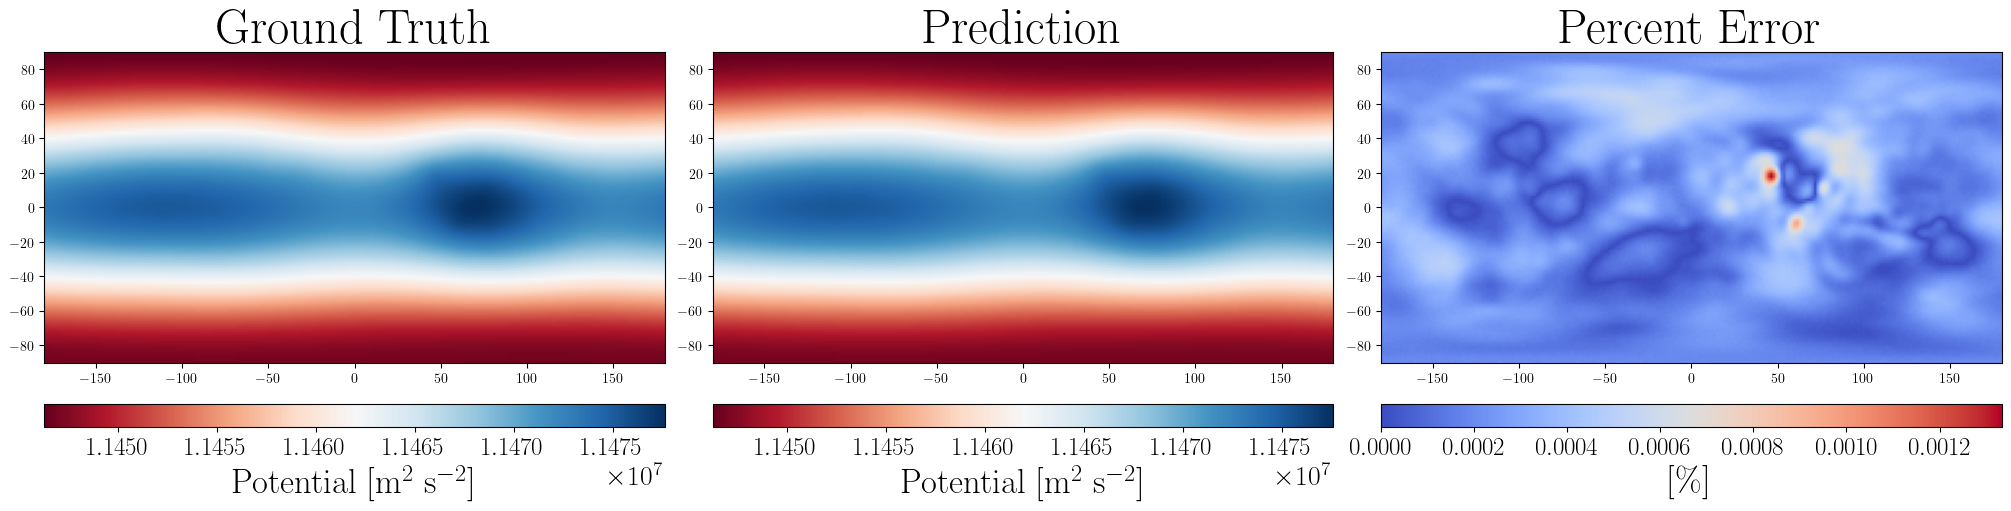

In [62]:
from matplotlib.gridspec import GridSpec

fig= plt.figure(figsize = (20, 5), constrained_layout = True)
gs = GridSpec(2, 3, figure=fig, height_ratios=[1.0, 0.06])

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(gt.detach(), extent=[-180,180,-90,90], cmap = "RdBu")
ax1.set_title('Ground Truth', fontsize=35, fontweight = "bold")
cax1 = fig.add_subplot(gs[1, 0])

cbar1 =fig.colorbar(im1, cax = cax1, orientation = "horizontal")
cbar1.set_label(r"Potential [m$^2$ s$^{-2}$]", fontsize = 25)
cbar1.ax.tick_params(labelsize=18) 
cbar1.ax.xaxis.get_offset_text().set_fontsize(20)

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(ypreds.detach(), extent=[-180,180,-90,90], cmap = "RdBu")
ax2.set_title("Prediction", fontsize = 35, fontweight = "bold")
cax2 = fig.add_subplot(gs[1, 1])

cbar2 = fig.colorbar(im2, cax = cax2, orientation = "horizontal")
cbar2.set_label(r"Potential [m$^2$ s$^{-2}$]", fontsize = 25)
cbar2.ax.tick_params(labelsize=18) 
cbar2.ax.xaxis.get_offset_text().set_fontsize(20)

ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(mape.detach(), extent=[-180,180,-90,90], cmap = "coolwarm")
ax3.set_title("Percent Error", fontsize = 35, fontweight = "bold")
cax3 = fig.add_subplot(gs[1, 2])

cbar3 = fig.colorbar(im3, cax = cax3, orientation = "horizontal")
cbar3.set_label("[$\%$]", fontsize = 25)
cbar3.ax.tick_params(labelsize=18) 

plt.savefig("attributes/gravity.pdf")
plt.show()

In [58]:
snr_test_ = 10 * torch.log10(torch.mean(ypreds**2) / torch.mean((ypreds - gt)**2))
rmse_ = torch.mean((ypreds - gt)**2).sqrt()
mae_ = torch.mean((ypreds - gt).abs())
mape_ = 100 * torch.mean((ypreds - gt).abs() / gt.abs())
print(f"Test SNR = {snr_test_:.3f} dB")
print(f"RMSE = {rmse_:.5e}")
print(f"MAE = {mae_:.5e}")
print(f"MAPE = {mape_:.5e}")

Test SNR = 111.505 dB
RMSE = 3.04762e+01
MAE = 2.67633e+01
MAPE = 2.33529e-04
